In [176]:
from importlib import reload
import numpy as np
import scipy.linalg
import linalg
reload(linalg)
import pywren
reload(pywren)
import math
import itertools
import time
import cloudpickle
import importlib
import sys
from sklearn.datasets import fetch_mldata
from itertools import groupby
from operator import itemgetter
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn import metrics
import sys
import boto3
reload(boto3)


<module 'boto3' from '/home/ubuntu/anaconda3/lib/python3.6/site-packages/boto3/__init__.py'>

In [2]:
import os

In [3]:
os.environ

environ({'EVENT_NOEPOLL': '1', 'HOME': '/home/ubuntu', 'LANG': 'en_US.UTF-8', 'LESSCLOSE': '/usr/bin/lesspipe %s %s', 'LESSOPEN': '| /usr/bin/lesspipe %s', 'LOGNAME': 'ubuntu', 'LS_COLORS': 'rs=0:di=01;34:ln=01;36:mh=00:pi=40;33:so=01;35:do=01;35:bd=40;33;01:cd=40;33;01:or=40;31;01:mi=00:su=37;41:sg=30;43:ca=30;41:tw=30;42:ow=34;42:st=37;44:ex=01;32:*.tar=01;31:*.tgz=01;31:*.arc=01;31:*.arj=01;31:*.taz=01;31:*.lha=01;31:*.lz4=01;31:*.lzh=01;31:*.lzma=01;31:*.tlz=01;31:*.txz=01;31:*.tzo=01;31:*.t7z=01;31:*.zip=01;31:*.z=01;31:*.Z=01;31:*.dz=01;31:*.gz=01;31:*.lrz=01;31:*.lz=01;31:*.lzo=01;31:*.xz=01;31:*.bz2=01;31:*.bz=01;31:*.tbz=01;31:*.tbz2=01;31:*.tz=01;31:*.deb=01;31:*.rpm=01;31:*.jar=01;31:*.war=01;31:*.ear=01;31:*.sar=01;31:*.rar=01;31:*.alz=01;31:*.ace=01;31:*.zoo=01;31:*.cpio=01;31:*.7z=01;31:*.rz=01;31:*.cab=01;31:*.jpg=01;35:*.jpeg=01;35:*.gif=01;35:*.bmp=01;35:*.pbm=01;35:*.pgm=01;35:*.ppm=01;35:*.tga=01;35:*.xbm=01;35:*.xpm=01;35:*.tif=01;35:*.tiff=01;35:*.png=01;35:*.svg=0

In [9]:
notebook_stdout = sys.stdout
notebook_stderr = sys.stderr
terminal_stdout = open('/dev/stdout', 'w')
terminal_stderr = open('/dev/stderr', 'w')

In [10]:
train_data = np.load("imagenet_features_alexnet_fc7.npz")

In [12]:
X_train = train_data["X_train"]
y_train = train_data["y_train"]
y_train_one_hot = np.eye(1000)[y_train]

In [13]:
%time X_train_sharded = linalg.ShardedMatrix("imagenet-train", data=X_train, shard_size_0=4096, bucket="imagenet-raw", reshard=False, n_jobs=8)

CPU times: user 80 ms, sys: 48 ms, total: 128 ms
Wall time: 165 ms


In [14]:
np.random.seed(0)
%time w = np.random.randn(X_train_sharded.shape[0], 1000)

CPU times: user 1min 29s, sys: 2.42 s, total: 1min 31s
Wall time: 1min 31s


In [15]:
%time w_full = linalg.ShardedMatrix(hash_key="w_full", data=w, shard_size_0=4096, bucket="imagenet-raw", n_jobs=8, reshard=False)

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 56.9 ms


In [16]:
%time w_small = linalg.ShardedMatrix(hash_key="w_small", data=w[:, :100], shard_size_0=4096, bucket="imagenet-raw", n_jobs=8, reshard=False)

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 59.2 ms


In [17]:
%time w_tiny = linalg.ShardedMatrix(hash_key="w_tiny", data=w[:, :10], shard_size_0=4096, bucket="imagenet-raw", n_jobs=8, reshard=False)

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 113 ms


###### X_train_sharded

In [18]:
# set up pywren
pwex = pywren.default_executor()

In [19]:
num_blocks = int(math.ceil(X_train_sharded.shape[0]/float(X_train_sharded.shard_size_0)))
tasks_per_job = 5
num_jobs = 2500

In [21]:
chunked_blocks = linalg.generate_chunked_block_pairs(num_blocks, tasks_per_job, num_jobs)

In [22]:
X_train_sharded.shard_size_0

4096

In [178]:
all_futures = [] 
all_times = []
gamma = 1e-3
lambdav = 1e-2

In [20]:
all_futures = []
for c in chunked_blocks:
    %time kernel_futures = pwex.map(lambda x: linalg.compute_rbf_kernel_blockwise(x, X_train_sharded, gamma), c)
    %time pywren.wait(kernel_futures)
    all_futures.extend(kernel_futures)

CPU times: user 1min 6s, sys: 0 ns, total: 1min 6s
Wall time: 22.3 s
CPU times: user 3min 51s, sys: 0 ns, total: 3min 51s
Wall time: 2min 52s
CPU times: user 1min 9s, sys: 0 ns, total: 1min 9s
Wall time: 24.3 s
CPU times: user 4min 2s, sys: 0 ns, total: 4min 2s
Wall time: 2min 36s
CPU times: user 1min 12s, sys: 0 ns, total: 1min 12s
Wall time: 25.8 s
CPU times: user 4min 12s, sys: 0 ns, total: 4min 12s
Wall time: 2min 43s
CPU times: user 1min 8s, sys: 0 ns, total: 1min 8s
Wall time: 23.9 s
CPU times: user 4min 1s, sys: 708 ms, total: 4min 2s
Wall time: 2min 43s


In [180]:
K_sharded = linalg.compute_rbf_kernel_blockwise([(0,0)], X_train_sharded, gamma)[1]

In [166]:
K_sharded.s3 = None

In [114]:
%time K_sharded.get_block(0,1)

CPU times: user 224 ms, sys: 340 ms, total: 564 ms
Wall time: 826 ms


array([[  1.12428400e-03,   6.08959934e-04,   1.15349772e-03, ...,
          1.61543547e-04,   5.75634185e-04,   3.32113565e-03],
       [  2.84973183e-04,   2.11321560e-04,   1.71494801e-04, ...,
          1.85739831e-04,   1.86005549e-04,   1.31913414e-03],
       [  3.04734014e-04,   2.73728481e-04,   1.23047255e-04, ...,
          5.91395874e-05,   2.12307539e-04,   1.27603440e-03],
       ..., 
       [  4.04208731e-05,   1.69449311e-04,   3.75688323e-05, ...,
          6.69192514e-06,   8.18111075e-05,   3.38597718e-04],
       [  6.39956852e-04,   7.37112190e-04,   2.46751471e-04, ...,
          3.00953485e-04,   5.35777945e-04,   4.60511725e-03],
       [  4.02032219e-06,   7.59927707e-06,   4.37292556e-06, ...,
          1.52175676e-06,   1.17406180e-05,   3.04515979e-05]], dtype=float32)

In [ ]:
%time chunked_blocks = linalg.pywren_matrix_vector_multiply(pwex, K_sharded, w_tiny, col_chunk_size=10, row_chunk_size=1000)

Num total chunks 10016
Chunk 0
[(0, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), (0, [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), (0, [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), (0, [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]), (0, [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]), (0, [50, 51, 52, 53, 54, 55, 56, 57, 58, 59]), (0, [60, 61, 62, 63, 64, 65, 66, 67, 68, 69]), (0, [70, 71, 72, 73, 74, 75, 76, 77, 78, 79]), (0, [80, 81, 82, 83, 84, 85, 86, 87, 88, 89]), (0, [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]), (0, [100, 101, 102, 103, 104, 105, 106, 107, 108, 109]), (0, [110, 111, 112, 113, 114, 115, 116, 117, 118, 119]), (0, [120, 121, 122, 123, 124, 125, 126, 127, 128, 129]), (0, [130, 131, 132, 133, 134, 135, 136, 137, 138, 139]), (0, [140, 141, 142, 143, 144, 145, 146, 147, 148, 149]), (0, [150, 151, 152, 153, 154, 155, 156, 157, 158, 159]), (0, [160, 161, 162, 163, 164, 165, 166, 167, 168, 169]), (0, [170, 171, 172, 173, 174, 175, 176, 177, 178, 179]), (0, [180, 181, 182, 183, 184, 185, 186, 187, 188, 18

In [100]:
len(Kw_pywren[-3])

32

In [67]:
out = list(map(lambda x: x.result(), Kw_pywren))

In [74]:
np.sum(out, axis=0).shape

(3215, 100)

In [178]:
import os

In [8]:
X = np.random.randn(40960, 4096)
%time X.T.dot(X)

CPU times: user 2min 14s, sys: 1.7 s, total: 2min 16s
Wall time: 3.71 s


array([[  4.04862146e+04,   7.82705786e+01,  -1.63919005e+02, ...,
         -3.10576924e+02,   4.79390747e+01,   5.12129183e+01],
       [  7.82705786e+01,   4.13399135e+04,   3.09159287e+02, ...,
          8.17000707e+01,   3.23654911e+02,   8.46396854e+01],
       [ -1.63919005e+02,   3.09159287e+02,   4.06385958e+04, ...,
         -3.85561935e+02,  -3.70171392e+02,  -5.42317473e+01],
       ..., 
       [ -3.10576924e+02,   8.17000707e+01,  -3.85561935e+02, ...,
          4.02843555e+04,   1.77182939e+01,   2.00371581e+02],
       [  4.79390747e+01,   3.23654911e+02,  -3.70171392e+02, ...,
          1.77182939e+01,   4.14973328e+04,  -3.64124520e+01],
       [  5.12129183e+01,   8.46396854e+01,  -5.42317473e+01, ...,
          2.00371581e+02,  -3.64124520e+01,   4.07074081e+04]])

In [91]:
def foo(x):
    return linalg.blocks_matrix_multiply([281, x], K_sharded, w_full)
    

In [154]:
K_sharded.s3 = None

In [59]:
%time foo_out = pwex.map(foo, [range(30)])
%time pywren.wait(foo_out)

CPU times: user 484 ms, sys: 52 ms, total: 536 ms
Wall time: 848 ms
CPU times: user 1.5 s, sys: 416 ms, total: 1.92 s
Wall time: 1min 45s


([<pywren.future.ResponseFuture at 0x7f59001202b0>], [])

In [87]:
K_sharded.get_block(0,0)

Getting Blocks 0, 0


array([[  1.00000095e+00,   1.66100182e-03,   2.73135235e-03, ...,
          1.81061390e-04,   3.27305146e-03,   2.85927181e-05],
       [  1.66100182e-03,   9.99999523e-01,   4.38424817e-04, ...,
          1.49767278e-04,   2.07018433e-03,   2.22248364e-05],
       [  2.73135118e-03,   4.38424817e-04,   1.00000095e+00, ...,
          8.40224020e-05,   1.50290085e-03,   1.48360841e-05],
       ..., 
       [  1.81061390e-04,   1.49767278e-04,   8.40224020e-05, ...,
          1.00000000e+00,   1.94332228e-04,   2.82612586e-06],
       [  3.27305146e-03,   2.07018433e-03,   1.50290166e-03, ...,
          1.94332228e-04,   9.99999046e-01,   3.45916815e-05],
       [  2.85927454e-05,   2.22248364e-05,   1.48360841e-05, ...,
          2.82612336e-06,   3.45916815e-05,   9.99999046e-01]], dtype=float32)

In [132]:
import concurrent.futures as fs
def fast_kernel_column_block_get(col_block, K, workers=1):
    s = time.time()
    with fs.ThreadPoolExecutor(max_workers=workers) as executor:
        futures = []
        for i in range(0,25):
            futures.append(executor.submit(K.get_block, i, col_block))
        fs.wait(futures)
        results = list(map(lambda x: x.result(), futures))
    e = time.time()
    
    return np.vstack(results), e - s
    
            
        

In [121]:
def kernel_column_block_get(col_block, K):
    results = []
    for i in range(0,25):
        results.append(K.get_block(i, col_block))
    return np.vstack(results)

In [169]:
times = []

In [155]:
K_sharded.s3 = boto3.client('s3')

In [156]:
for i in range(11,20):
    print(i)
    _, t = fast_kernel_column_block_get(0, K_sharded, i)
    times.append(t)

11
12
13
14
15
16
17
18
19


In [157]:
len(times)

19

In [158]:
bw = list(map(lambda x: 1600/x, times))

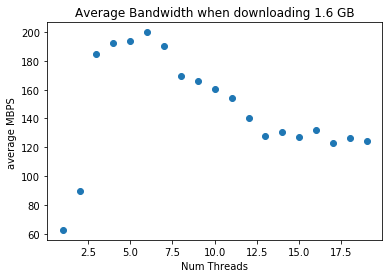

In [162]:
scatter(x=range(1,len(times)+1), y=bw)
plt.title("Average Bandwidth when downloading 1.6 GB")
plt.ylabel("average MBPS ")
plt.xlabel("Num Threads")

In [122]:
K_sharded.s3 = boto3.client('s3')

In [131]:
%time K_block_0 = fast_kernel_column_block_get(0, K_sharded, workers=7)

CPU times: user 12.3 s, sys: 6.42 s, total: 18.7 s
Wall time: 10.1 s


In [107]:
%time K_block_0 = kernel_column_block_get(0, K_sharded)

Getting Blocks 0, 0
Time to get 0.008860588073730469
Time to load 0.04375624656677246
Getting Blocks 1, 0
Time to get 0.008844614028930664
Time to load 0.038953304290771484
Getting Blocks 2, 0
Time to get 0.0046901702880859375
Time to load 0.039229631423950195
Getting Blocks 3, 0
Time to get 0.007628440856933594
Time to load 0.0410003662109375
Getting Blocks 4, 0
Time to get 0.005826473236083984
Time to load 0.038127899169921875
Getting Blocks 5, 0
Time to get 0.004324913024902344
Time to load 0.03684091567993164
Getting Blocks 6, 0
Time to get 0.007924079895019531
Time to load 0.05362129211425781
Getting Blocks 7, 0
Time to get 0.0062334537506103516
Time to load 0.04109930992126465
Getting Blocks 8, 0
Time to get 0.006711244583129883
Time to load 0.0396573543548584
Getting Blocks 9, 0
Time to get 0.005319118499755859
Time to load 0.042035818099975586
Getting Blocks 10, 0
Time to get 0.0056455135345458984
Time to load 0.0369725227355957
Getting Blocks 11, 0
Time to get 0.00448751449584

In [83]:
%time KbTK = K_block_0.T.dot(K_block_0)

CPU times: user 13min 31s, sys: 0 ns, total: 13min 31s
Wall time: 21 s


In [79]:
K_block_0.shap

(461967, 4096)

In [133]:
all_chunks, num_col_chunks = linalg.matrix_chunk(313, 313, 10)

In [135]:
chunked_blocks = list(linalg.chunk(all_chunks, 3000))

In [153]:
chunked_out = list(chunk(chunked_blocks[0], num_col_chunks))

[[(187, [160, 161, 162, 163, 164, 165, 166, 167, 168, 169]),
  (187, [170, 171, 172, 173, 174, 175, 176, 177, 178, 179]),
  (187, [180, 181, 182, 183, 184, 185, 186, 187, 188, 189]),
  (187, [190, 191, 192, 193, 194, 195, 196, 197, 198, 199]),
  (187, [200, 201, 202, 203, 204, 205, 206, 207, 208, 209]),
  (187, [210, 211, 212, 213, 214, 215, 216, 217, 218, 219]),
  (187, [220, 221, 222, 223, 224, 225, 226, 227, 228, 229]),
  (187, [230, 231, 232, 233, 234, 235, 236, 237, 238, 239]),
  (187, [240, 241, 242, 243, 244, 245, 246, 247, 248, 249]),
  (187, [250, 251, 252, 253, 254, 255, 256, 257, 258, 259]),
  (187, [260, 261, 262, 263, 264, 265, 266, 267, 268, 269]),
  (187, [270, 271, 272, 273, 274, 275, 276, 277, 278, 279]),
  (187, [280, 281, 282, 283, 284, 285, 286, 287, 288, 289]),
  (187, [290, 291, 292, 293, 294, 295, 296, 297, 298, 299]),
  (187, [300, 301, 302, 303, 304, 305, 306, 307, 308, 309]),
  (187, [310, 311, 312]),
  (188, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
  (188, [10, 11, 1

In [160]:
len(list(filter(lambda x: x[0] == 1, chunked_blocks[0])))

32

In [173]:
chunked_blocks[0]

array([ 2.43349681,  0.87474671,  0.50610103,  4.26870926,  2.094973  ,
       -0.61737127,  5.27321778,  0.07181849, -1.18891053, -2.26031702])

In [224]:
y_train

array([940, 569, 538, ..., 579,  39, 268])